# PSET 13: The Moriarty Brain Atlas
### By Aishwarya Chander for MCB112 for Fall 2021

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.manifold import TSNE
from matplotlib.pyplot import figure
from scipy.optimize import bisect, minimize

## Part 0: Import, Clean and Save the data
For this PSET, we're working with two data sets. 
> **Small dataset**: Consists of mapped read count data for 40 cells and 24 genes. The last column in the data table identifies the known cell type labels 0-7 for 8 different neural cell types.

> **Large dataset**: Consists of mapped read counts for 2131 cells and 32 genes, and the last column assigns labels 0-15 for 16 different neural cell types.

We'll set the index with the values in the last column, which defines the cell type corresponding to each entry for both datasets.

### Small Dataset

In [2]:
# Import small data into a dataframe
small_data = pd.read_table('w13-data-small.tbl', delim_whitespace=True, index_col = 'type')
small_data.head()

,asparagus,plantain,okra,elderberry,artichoke,raisin,potato,strawberry,ginger,rhubarb,...,mulberry,pineapple,banana,fig,chestnut,lettuce,thyme,cranberry,cabbage,beet
type,,,,,,,,,,,,,,,,,,,,,
2,0,18,0,39,0,124,61,1,84,90,...,50,93,138,124,123,44,60,76,1,99
3,0,274,242,195,0,42,92,4,257,97,...,50,132,177,156,214,70,28,151,126,71
7,313,116,41,128,328,162,68,156,160,272,...,291,215,32,324,99,163,77,78,201,658
6,130,51,1,237,32,104,315,273,12,95,...,97,147,23,91,516,389,72,262,1,264
5,182,131,39,2,52,48,3,76,9,68,...,32,12,36,207,0,110,41,344,121,1


In [3]:
small_data.shape # confirms that we have the right data

(40, 24)

In [4]:
# We'll extract the index column into a list to use it for clustering color assignment in Part 1
small_gene_types = small_data.index.tolist()

In [5]:
# We can use this to check if our clustering plots match the counts within each cluster manually. 
# Just an extra check! 

small_gene_size = np.unique(small_gene_types, return_counts=True)

types_s = small_gene_size[0].tolist()
counts_s = small_gene_size[1].tolist()

cellcounts_s = pd.DataFrame(counts_s, types_s, columns = ["Cell Counts"])
cellcounts_s

,Cell Counts
0,4
1,4
2,5
3,6
4,6
5,5
6,5
7,5


### Large Dataset

In [6]:
large_data = pd.read_table('w13-data-large.tbl', delim_whitespace=True, index_col = 'type')
large_data.head()

,strawberry,arugula,rhubarb,beet,banana,cranberry,elderberry,raisin,watermelon,tomato,...,kiwi,quince,asparagus,olive,kohlrabi,chickpea,potato,fennel,thyme,plantain
type,,,,,,,,,,,,,,,,,,,,,
6,0,20,24,110,26,25,358,0,21,83,...,2,260,0,63,12,42,613,253,25,0
9,39,30,15,0,59,35,0,27,74,45,...,120,1,329,70,0,255,2,67,92,152
8,358,4,97,0,60,52,0,2,19,282,...,71,0,132,71,0,7,0,148,39,2
11,152,273,95,0,46,31,2,317,81,79,...,46,155,96,159,52,67,0,132,68,275
2,2,102,118,0,37,65,2,1,222,51,...,1,540,0,50,144,144,1,187,106,1


In [7]:
large_data.shape # confirms that we have the right data

(2131, 32)

In [8]:
# We'll extract the index column into a list to use it for clustering color assignment in Part 1
large_gene_types = large_data.index.tolist()

In [9]:
# We can use this to check if our clustering plots match the counts within each cluster manually. 
# Just an extra check! 
large_gene_size = np.unique(large_gene_types, return_counts=True)

types_l = large_gene_size[0].tolist()
counts_l = large_gene_size[1].tolist()

cellcounts_l = pd.DataFrame(counts_l, types_l, columns = ["Cell Counts"])
cellcounts_l

,Cell Counts
0,89
1,117
2,194
3,181
4,61
5,133
6,83
7,157
8,197
9,193


Great! At this point, we have our data available as a data frame, we have a list of what cell type corresponds to each entry, we know the shape of our data matrices and we have an estimate of how many cells of each cell type are present within the dataset. 

We'll move on to analyzing our data using PCA, a self-implemented tSNE and Python's _sklearn.manifold.TSNE_ algorithm.

## Part 1: Verify that PCA fails

Let's import code from PSET 11 for PCA. We'll follow the same procedure as before and use log transformed data to run singular value decomposition to try and assign clusters for each cell type based on gene expression. 

In [10]:
## Define function that finds PCs of data set

def PCA(data):

    # Centering the data
    col_mean = data.mean(axis=0)          # Take the mean value of each column
    cent_data = data - col_mean           # Subtract column means against each row
    
    # Use numpy's SVD function to find U, S and W's transpose
    U, S, WT = np.linalg.svd(cent_data)   
    
    W = WT.T                              # Take transpose of WT to recover W - Eigenvectors
    lam = (S**2)/(len(S)-1)               # Convert to Eigenvalues lambda
    
    return cent_data, U, S, W, lam

### PCA for the Small Dataset

In [11]:
# Read data into numpy arrays
small_data_vals = small_data.to_numpy() 

# Manually Log transform the data into a log(1+counts) format for easy operation throughout the notebook 
# and to avoid log(0) errors that I got several times in PSET 05
sd    = np.log(1 + small_data_vals) 

# Identify the shape of your matrix: Essential for Sanity Checks!
sd.shape

(40, 24)

In [12]:
# run PCA by singular value decomposition method
data_sd, U_sd, S_sd, W_sd, lam_sd = PCA(sd)

# We're going to assume that most of the data is stored in the first two PCs.
# Extract Scores of the first two PCs against the centered matrix
pc1_score_sd = data_sd @ W_sd[:,0]
pc2_score_sd = data_sd @ W_sd[:,1] 

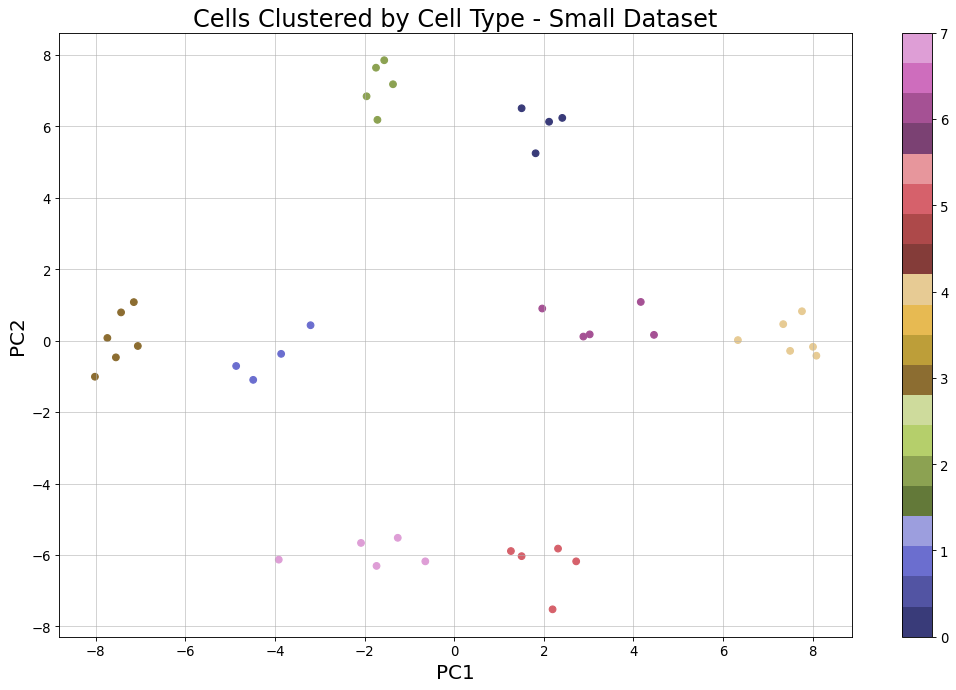

Figure 1: PCA to analyze cell types for the small dataset


In [13]:
# Set Figure Size
figure(figsize=(16, 10), dpi=80)

# Set Font Sizes
mpl.rcParams.update({'font.size': 18})
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 


# Define Plotting Parameters
plt.scatter(pc1_score_sd, pc2_score_sd, c = small_gene_types, cmap = 'tab20b') # Plot by cell type assignment values 
plt.grid(linewidth=0.5)
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cells Clustered by Cell Type - Small Dataset')
plt.show()

print("Figure 1: PCA to analyze cell types for the small dataset")

It seems like PCA works for the small dataset, but what happens when we implement it to the larger dataset that is possibly harder to flatten due to the general non-linear nature of the data? 

### PCA for the Large Dataset

In [14]:
# Read data into numpy arrays
large_data_vals = large_data.to_numpy() 

# Manually Log transform the data into a log(1+counts) format for easy operation throughout the notebook 
# and to avoid log(0) errors that I got several times in PSET 05
ld    = np.log(1 + large_data_vals) 

# Identify the shape of your matrix: Essential for Sanity Checks!
ld.shape

(2131, 32)

In [15]:
# run PCA by singular value decomposition method
data, U, S, W, lam = PCA(ld)

# We're going to assume that most of the data is stored in the first two PCs.
# Extract Scores of the first two PCs against the centered matrix
pc1_score = data @ W[:,0]
pc2_score = data @ W[:,1] 

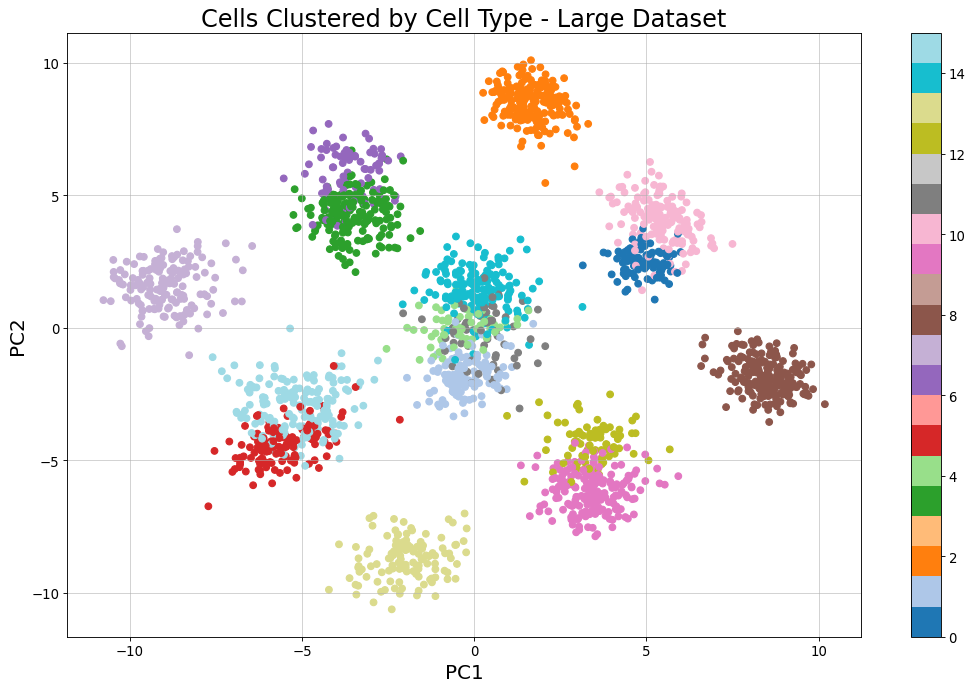

Figure 2: PCA to analyze cell types for the large dataset


In [16]:
# Set Figure Size
figure(figsize=(16, 10), dpi=80)

# Set Font Sizes
mpl.rcParams.update({'font.size': 18})
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 


# Define Plotting Parameters
plt.scatter(pc1_score, pc2_score, c = large_gene_types, cmap = 'tab20') # Plot by cell type assignment values 
plt.grid(linewidth=0.5)
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cells Clustered by Cell Type - Large Dataset')
plt.show()


print("Figure 2: PCA to analyze cell types for the large dataset")

By running PCA on the large dataset, we can see that there are around 9 clusters for the 16 cell types. PCA tends to fail for high-volume non-linear data as PCA works under the assumption that the given data is linear. When PCA optimizes the variance of the given data in the least number of dimensions, it does not take into account the linearity or dimensions of the dataset, and only cares about the variance it observes. 

To visualize non-linear data, we can implement a different algorithm called tSNE, or t-distributed  stochastic neighbor embedding. 

## Part 2: Implement tSNE

tSNE is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map. 

The t-SNE algorithm comprises two main stages. 

> First, t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects are assigned a higher probability while dissimilar points are assigned a lower probability. 

> Second, t-SNE defines a similar probability distribution over the points in the low-dimensional map, and it minimizes the Kullback–Leibler divergence (KL divergence) between the two distributions with respect to the locations of the points in the map. 

tSNE is primarily used to visualize clustering data, but a drawback is that it can falsely generate clusters even when there is no clustering within the dataset due to the 'perplexity' parameter.

#### Note: This section is heavily referenced from the section notes for this week. 

    Prelude:
        1. We'll be using log transformed data for all the cases as it provides better calculations.
        
        2. This algorithm will only work for the smaller dataset (unless you have a couple days). The local parameters within the functions are defined keeping this in mind and are hard coded in some places to bypass errors.
        
        3. Since tSNE is a compilation of several different components and 2 optimizations, I have gone ahead and tested every output to ensure that the transformations are accurate and reflective of the task the function is executing. 
        This makes the code appear a little lengthier than it is and is an optional test step that can be skipped. 


#### 1. Calculate the distance matrix

The euclidean distance between the two points is given by 

$$d_{ij} = ||x_i-x_j||$$


And the conditional probability that $j$ is $i$'s neighbor is

$$p_{j|i} = \frac{\exp(\frac{-d_{ij}^2}{2\sigma_i^2})}{\sum_k\exp(\frac{-d_{ik}^2}{2\sigma_i^2})}$$

In [17]:
# define a function to calculate the Euclidean distances between two vecotrs in a matrix

def calculate_dist(X):
   
    # calculate the distance between each pair of points in the dataset, storing in a matrix D 
    # pre-calculate the matrix
    n = X.shape[0]
    D = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            
            # calculate the distance between a pair of unequal points 
            if i != j:
                D[i][j] = np.linalg.norm(X[i] - X[j], ord = 2)
            
            # calculate the distance between a pair of equal points
            else:
                D[i][j] = -float('Inf')
    
    return D

In [18]:
# Test distance matrix
D = calculate_dist(sd)
D

array([[       -inf,  9.98689585, 15.0832254 , ..., 11.22632642,
        11.9437521 , 15.64135221],
       [ 9.98689585,        -inf, 11.95996462, ...,  4.63403428,
        14.61033973, 12.91071225],
       [15.0832254 , 11.95996462,        -inf, ..., 11.9261573 ,
        12.50193122, 10.73736892],
       ...,
       [11.22632642,  4.63403428, 11.9261573 , ...,        -inf,
        15.18657479, 12.96777646],
       [11.9437521 , 14.61033973, 12.50193122, ..., 15.18657479,
               -inf,  9.40011759],
       [15.64135221, 12.91071225, 10.73736892, ..., 12.96777646,
         9.40011759,        -inf]])

#### 2. Calculate sigma (first of 2 optimizations in t-SNE algorithm)

The Shannon entropy is calculated as:

$$ H_i = - \sum_j p_{j \mid i} \log_2 p_{j \mid i} $$

where sigma is introduced into the equation through the $p_{j|i}$ term

And perplexity is calculated by: $$ \mathrm{Perplexity} = 2^H$$

In [19]:
# define a function to calculate the difference of true perplexity and the estimated perplexity

def perp_diff(sigma_i, D_i, perp_true):
    
    # normalize p_ji 
    p_ji = np.exp((-np.square(D_i))/(2*(np.square(sigma_i))))
    if sum(p_ji) != 0:
        p_ji = p_ji / sum(p_ji)
    
    # calculate the entropy 
    entropy = 0
    for j in range(len(D_i)):
        if p_ji[j] != 0:
            entropy -= p_ji[j] * np.log2(p_ji[j])
    
    # calculate estimated perplexity 
    perp_est = 2**entropy
    
    # calculate difference between perplexity_true and estimated
    diff = perp_est - perp_true
    
    return diff

In [20]:
# given a perplexity value, find a sigma that satisfies it

def calculate_sigma(perp_true, XS, XL):
    
    # Selecting a random integer value, 8, as that would be the perplexity value I assign
    a = 8 * max(np.max(XS), np.max(XL))
    b = 8 ** (-4)
    
    # Zero matrix for sigma
    sigma = np.zeros((XS.shape[0]))

    # use scipy.optimize.bisect() to calculate sigma[i]
    for i in range(XS.shape[0]):
        sigma[i] = bisect(perp_diff, b, a, args=(calculate_dist(XS)[i], perp_true))
    
    return sigma

In [21]:
# Test sigma values
sigma = calculate_sigma(8, sd, ld)
sigma

array([3.55949851, 3.53711864, 3.359713  , 3.53396538, 3.61711079,
       3.5214925 , 3.39321955, 3.26518478, 3.60927096, 3.85392676,
       3.80013   , 3.60396494, 3.2043765 , 3.7086081 , 3.44963955,
       3.42555515, 3.58705102, 3.36352445, 3.37706486, 3.72452738,
       3.53238537, 2.92287673, 3.48133099, 3.95795469, 3.77231001,
       3.67139428, 3.48638221, 3.4340525 , 3.3241569 , 3.51981038,
       3.42117556, 3.44857321, 3.68150142, 3.46590496, 3.98460777,
       3.29682441, 3.6014299 , 3.65217072, 3.14597895, 3.52436969])

In [22]:
# plt.plot(np.argsort(sigma))

#### 3. Calculate the conditional probability matrix:

$$p_{j \mid i} = \frac {                 \exp \left(  - \lVert x_i - x_j \rVert^2 \, / \, 2\sigma_i^2 \right) }
                        { \sum_{k \neq i} \exp \left(  - \lVert x_i - x_k \rVert^2 \, / \, 2\sigma_i^2 \right) }$$
                        
which can be written as: 

$$p_{j|i} = \frac{\exp(\frac{-d_{ij}^2}{2\sigma_i^2})}{\sum_k\exp(\frac{-d_{ik}^2}{2\sigma_i^2})}$$

and then, 

#### 4. Calculate the probability matrix: 

$$P_{ij} = \frac{P_{i|j}+P_{j|i}}{2N}$$

#### 5. Calculate the transpose of the probability matrix: 
$$P_{ji} = (P_{ij})' $$

In [23]:
# Calculate actual probability matrix pij
# Shape = n x n

def calculate_pij(X, sigma, D):
    
    # reference matrix shape
    n = X.shape[0]
    
    # Set a conditional probability matrix
    cond_p_ji = np.zeros((n, n)) 
    # Set a defined probability matrix
    pij = np.zeros((n, n))
    
    # Calcuate the numerator for the conditional probability term
    for i in range(n):
        for j in range(n):
            cond_p_ji[i][j] = np.exp((-D[i][j]**2)/(2*(sigma[i]**2)))
    
    # Calculate the denominator for the conditional probability term
    for i in range(n):
        cond_p_ji[i] = cond_p_ji[i] / cond_p_ji[i].sum()
   
    # Normalize over 2N values to get the probability matrix
    for i in range(n):
        for j in range(n):
            # 0 along the diagonals
            if i == j:
                pij[i][j] = 0
            # replicate formula for 
            else:
                pij[i][j] = (cond_p_ji[i][j] + cond_p_ji[j][i])/ (2*n)
    
    # Calculate Pji, transpose of Pij
    #for i in range(n):
        #for j in range(n):
            #pji = pij.T
            
    return pij

In [24]:
# Test Actual Probability Matrix
pij = calculate_pij(sd, calculate_sigma(8, sd, ld), calculate_dist(sd))
pij

array([[0.00000000e+00, 2.37812420e-04, 1.55354814e-06, ...,
        1.08982114e-04, 2.69064061e-05, 8.40296097e-07],
       [2.37812420e-04, 0.00000000e+00, 5.47487054e-05, ...,
        6.13287025e-03, 1.42403846e-06, 1.87497524e-05],
       [1.55354814e-06, 5.47487054e-05, 0.00000000e+00, ...,
        7.13383374e-05, 2.12448513e-05, 1.97265364e-04],
       ...,
       [1.08982114e-04, 6.13287025e-03, 7.13383374e-05, ...,
        0.00000000e+00, 1.39590787e-06, 2.37399418e-05],
       [2.69064061e-05, 1.42403846e-06, 2.12448513e-05, ...,
        1.39590787e-06, 0.00000000e+00, 3.27066042e-04],
       [8.40296097e-07, 1.87497524e-05, 1.97265364e-04, ...,
        2.37399418e-05, 3.27066042e-04, 0.00000000e+00]])

#### 6. Calculate the theoretical probability matrix:

$$ q_{ij} = \frac { \left( 1 + \lVert y_i - y_j \rVert^2 \right)^{-1} } { \sum_{k \neq l} \left( 1 + \lVert y_k - y_l \rVert^2 \right)^{-1} } $$

In [25]:
# Calculate theoretical probability matrix, Qij
# Shape = n x n

def calculate_qij(X, D):
    
    n = X.shape[0]
    
    # create an N x N matrix 
    qij = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            # 0 along the diagonal
            if i == j:
                qij[i][j] = 0
            
            # Calculate Qij, exclude distance matrix in the numerator
            else:
                qij[i][j] = 1 / (1 + D[i][j] ** 2) # skip ^-1
    
    # normalize Qij
    qij = qij / qij.sum()
    
    return qij

In [26]:
# Test the Theoretical Probability Matrix
qij = calculate_qij(sd, D)
qij

array([[0.        , 0.00064566, 0.00028464, ..., 0.00051202, 0.00045277,
        0.00026477],
       [0.00064566, 0.        , 0.00045155, ..., 0.00289407, 0.00030328,
        0.00038788],
       [0.00028464, 0.00045155, 0.        , ..., 0.0004541 , 0.0004135 ,
        0.0005593 ],
       ...,
       [0.00051202, 0.00289407, 0.0004541 , ..., 0.        , 0.0002808 ,
        0.00038449],
       [0.00045277, 0.00030328, 0.0004135 , ..., 0.0002808 , 0.        ,
        0.00072785],
       [0.00026477, 0.00038788, 0.0005593 , ..., 0.00038449, 0.00072785,
        0.        ]])

#### 7. Calculate KL divergence using this formula:
$$f(\mathbf{y}) = \mathrm{KL}(P \lVert Q) = \sum_i \sum_j p_{ij} \log \frac{p_{ij}} {q_{ij}}$$

#### 8. And subsequently, calculate the optimization gradient:
$$\frac {\partial f} {\partial y_i} = 4 \sum_j (p_{ij} - q_{ij}) (y_i - y_j) (1 + \lVert y_i - y_j \rVert^2)^{-1}$$

In [27]:
# Calculate KL divergence and obtain an optimization gradient

def KL_dist(Y, pij):

    # for each pair of points i and j: 
    # Calculate gradient for (i,j) and sum over all j's:
    # Calculate KL for each pair (i,) and sum over all i's and j's, taking care to avoid the zero entries
    
    n = pij.shape[0]
    Y = Y.reshape((n, 2))  # We must reshape Y into a Nx2 matrix because the scipy minimizer only accepts scalar and have forcefully converted Y into a scalar
    
    # calculate the distance matrix
    D = calculate_dist(Y)
    
    # calculate the theoretical probability matrix 
    qij = calculate_qij(Y, D)
    
    # Calculate KL divergence based on the given formula 
    KL = 0
    for i in range(n):
        for j in range(n):
            if (pij[i][j] != 0) and (qij[i][j] != 0):
                KL += pij[i][j] * np.log(pij[i][j] / qij[i][j])
                
    #######
    
    # Calculate the optimization gradient based on the given formula 
    gradient = np.zeros((n, 2))
    for i in range(n):
        for j in range(n):
            gradient[i] += 4 * (pij[i][j] - qij[i][j]) * (Y[i] - Y[j]) / (1 + D[i][j] ** 2) # skip ^-1 here too, fixed. 
    
    # Scale the gradient for minimization
    gradient = gradient.ravel()
    
    # Return KL and gradient
    return KL, gradient

In [52]:
# generate matrix of distances of the same shape as the small dataset
Y = np.random.normal(0 ,1e-4, (len(sd),2))

# Test KL function
KL, gradient = KL_dist(Y, pij)
print(KL) # KL - divergence
print(gradient) # Otimization gradient

1.5691517884618231
[ 6.95257704e-07 -5.58364760e-06 -4.71343413e-07  1.81542802e-06
 -5.13645794e-06  1.85805017e-06 -4.50552643e-07 -8.96441784e-07
 -5.15353708e-06 -6.26503920e-07 -6.64535061e-06  1.88137267e-06
  9.57004028e-06 -5.38946354e-06 -2.14938113e-06  5.21791627e-06
 -7.27595001e-06 -1.98748836e-06 -4.21952117e-06  3.79439101e-06
  6.73925528e-06 -4.84339652e-06  1.45786473e-07 -1.35766180e-06
 -3.68677521e-06  2.67498001e-06  6.60167460e-06 -4.21750411e-06
  1.73166314e-06 -2.70230607e-06 -3.38670536e-07  2.63309699e-06
 -3.96886838e-06 -7.42623475e-06  3.47350660e-06  4.67312515e-06
 -7.73829029e-08  1.55896984e-06 -3.79201083e-06 -6.05823954e-06
  1.66217330e-06  9.87926890e-08 -5.17047671e-06  1.46376940e-07
  7.47853916e-06 -2.31465427e-06  7.96768672e-06 -2.07248569e-06
 -2.39145604e-07 -1.05971955e-05  9.61112386e-07  1.18614721e-06
 -7.18460912e-06  5.40713550e-06 -4.20179538e-07  4.54268280e-06
  2.36431425e-06  5.00003997e-06 -6.08222825e-06  7.80377065e-06
  1.79

In [53]:
# Execute t-SNE and generate a 2D array for plotting

def AC_tSNE(perplexity_true, XS, XL):
    
    n = XS.shape[0]

    # Generate Y matrix of size N x 2
    Y = np.random.normal(0, 1e-4, (len(XS),2))
    
    # Calculate sigma values
    sigma = calculate_sigma(perplexity_true, XS, XL)
    
    # Calculate probability matrix 
    pij = calculate_pij(XS, sigma, calculate_dist(XS))
    
    # Optimize matrix using scipy.optimize.minimize
    Y_opt = minimize(KL_dist, Y, args=(pij), jac=True)
    
    # Reshape the matrix
    Y_opt = Y_opt.x.reshape((n, 2))
    
    return Y_opt

In [69]:
# Test our version of the tSNE function
np.random.seed(42)
Y_opt = AC_tSNE(8, sd, ld)
Y_opt

array([[-8.38925981, -2.70444266],
       [ 2.14171635, -7.82870513],
       [ 7.39458804,  2.26251944],
       [ 4.33983678,  6.59227323],
       [ 1.82952983,  0.17353793],
       [ 6.52165812,  1.71236077],
       [-0.42370127, -4.60769739],
       [-1.95088673,  5.93374193],
       [-5.49210431, -0.5224907 ],
       [ 2.64782253,  0.26847973],
       [-1.1418015 , -4.36697034],
       [ 3.13188747, -7.14954357],
       [ 7.63033515,  1.60206102],
       [-0.64117262, -4.84323801],
       [ 3.01845075,  7.18536501],
       [-1.57986094,  4.97708777],
       [-5.69106329,  0.07030695],
       [ 2.48989647, -7.05929969],
       [ 2.05665232,  0.81095011],
       [-6.05202298,  0.04862243],
       [ 2.67290458, -8.13844446],
       [ 6.06760007,  1.48608756],
       [-7.86570376, -2.56808108],
       [-8.88220597, -3.29345725],
       [-5.38842789, -0.42762266],
       [ 2.74486067, -6.83166669],
       [ 1.68492239,  0.79923171],
       [-1.31478907,  6.2410048 ],
       [ 3.70854597,

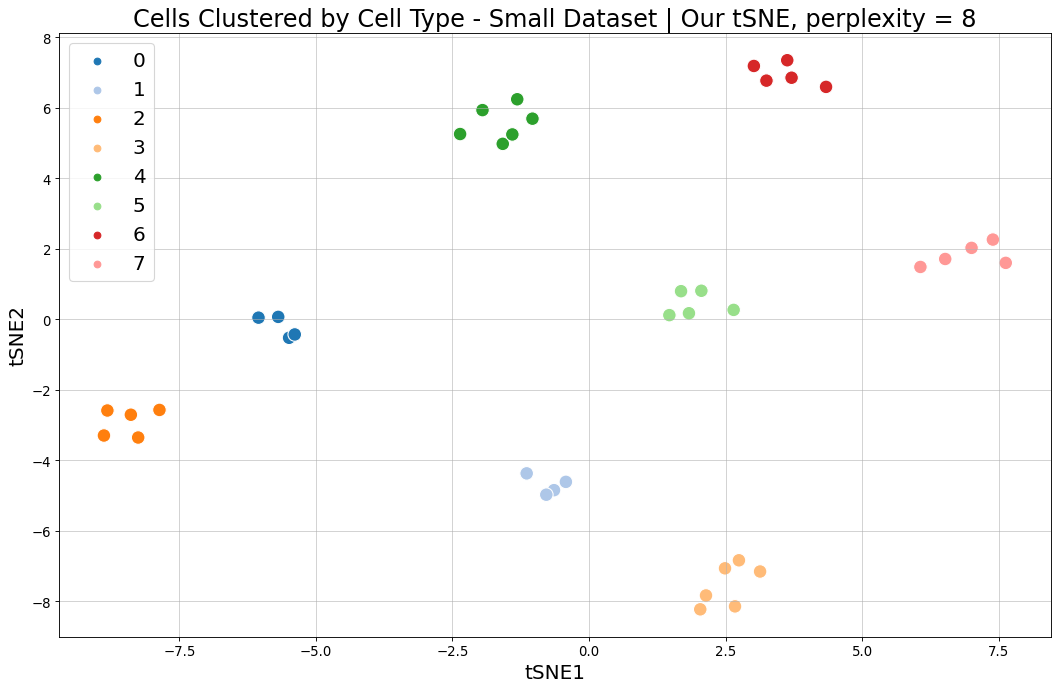

Figure 3: Aishwarya's tSNE to assign cell types for the small dataset


In [70]:
# Plot our implementation of tSNE to check if the clusters are generated

# Set Figure Size
figure(figsize=(16, 10), dpi=80)

# Set Font Sizes
mpl.rcParams.update({'font.size': 18})
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 

# Define Plotting Parameters
sns.scatterplot(
    x=Y_opt[:,0], y=Y_opt[:,1], # Define x, y axis
    hue = small_gene_types, # Set coloring criteria
    palette=sns.color_palette("tab20", 8), # choose color pallete and how many colors from the pallete
    s = 150, # Set point size
    data=sd # Select data
    )

plt.grid(linewidth=0.5) # Add grid lines
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.title('Cells Clustered by Cell Type - Small Dataset | Our tSNE, perplexity = 8')

plt.show()


print("Figure 3: Aishwarya's tSNE to assign cell types for the small dataset")

## Part 3: Canned TSNE

### Understanding a tSNE plot
    
At this point, it is important for us clustering fans to forget the following when trying to interpret the 
tSNE plots generated in the section below: 
 
>    1. The size of clusters in a tSNE plot means nothing: The dimensionality reduction component of the tSNE algorithm tends to naturally expand dense clusters, and contract sparse ones, evening out cluster sizes. 
    It's essential to note that you cannot see relative sizes of clusters in a t-SNE plot.
    
>    2. Distances between clusters may or may not mean anything: The distance between each cluster is a visual manifestation of the perplexity parameter. Depending on the perplexity value, we can observe a notable change in the global geometry, which might not be a good thing as it is often hard to find one value of perplexity that can represent true geometry of the dataset. In real data, multiple clusters with different numbers of elements and one perplexity value may not capture distances across all clusters accurately. It is good to take this value with a pinch of salt. 
    
>    3. With each run, you will get a different plotted output: In addition to seeing a different plot with each perplexity value, we will also see a different plot generated each time you run the algorithm. I believe this is because tSNE only really guarantee’s local convergence and not global geometry with each run. This does not have any implications on the results, but it's just something to keep in mind so you're not thrown off. We will see this in part 3.1 and 3.2. 

### Canned tSNE: Small Dataset

#### Perplexity = 8; Same as the number of Cell Types

In [32]:
X_sd = sd # load small dataset
Y_sd = TSNE(perplexity = 8).fit_transform(X_sd)

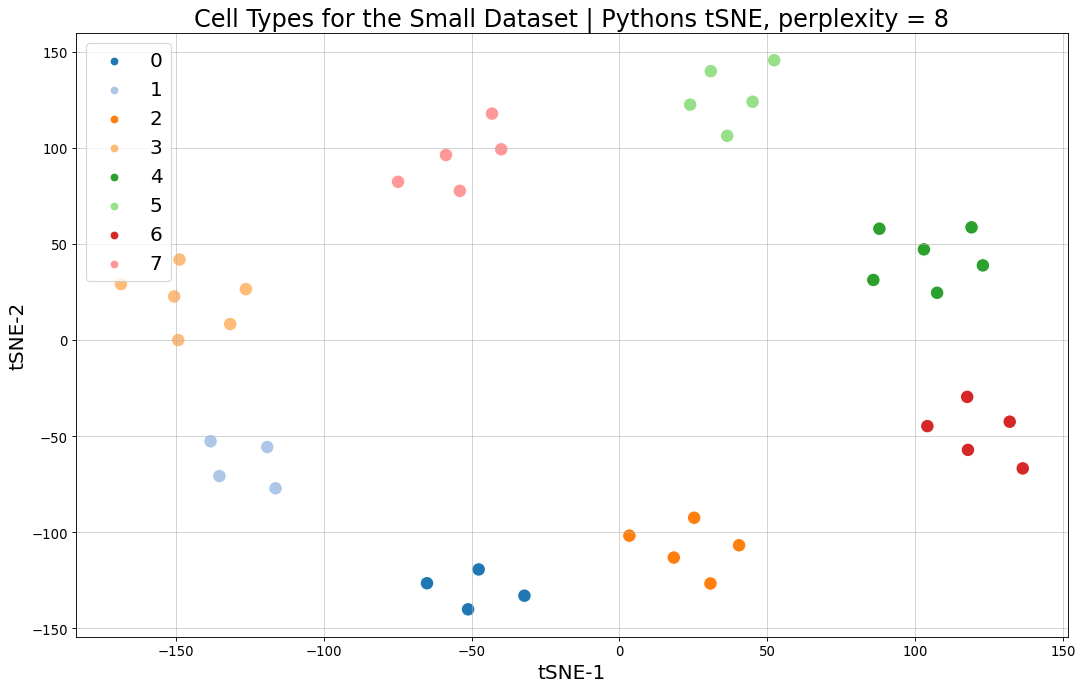

Figure 4: Canned tSNE to assign cell types for the small dataset


In [33]:
# Set plotting parameters
plt.figure(figsize=(16,10), dpi = 80)
plt.grid(linewidth=0.5)
plt.title('Cell Types for the Small Dataset | Pythons tSNE, perplexity = 8')
plt.xlabel('tSNE-1')
plt.ylabel('tSNE-2')

# Generate a Scatter plot
sns.scatterplot(
    x=Y_sd[:,0], y=Y_sd[:,1],
    hue = small_gene_types,
    palette=sns.color_palette("tab20", 8),
    s = 150,
    data=sd
    )


plt.show()


print("Figure 4: Canned tSNE to assign cell types for the small dataset")

### Canned tSNE: Large Dataset

While we were unable to run tSNE on the large dataset using our algorithm, we're able to use python's code to run this and plot. Here, we should be able to see each of the cell types sorted by cluster unlike what we saw in PCA. 

In [34]:
X_ld = ld # load large dataset

# Run sklearn.manifold.TSNE
Y_ld = TSNE(perplexity=16).fit_transform(X_ld)

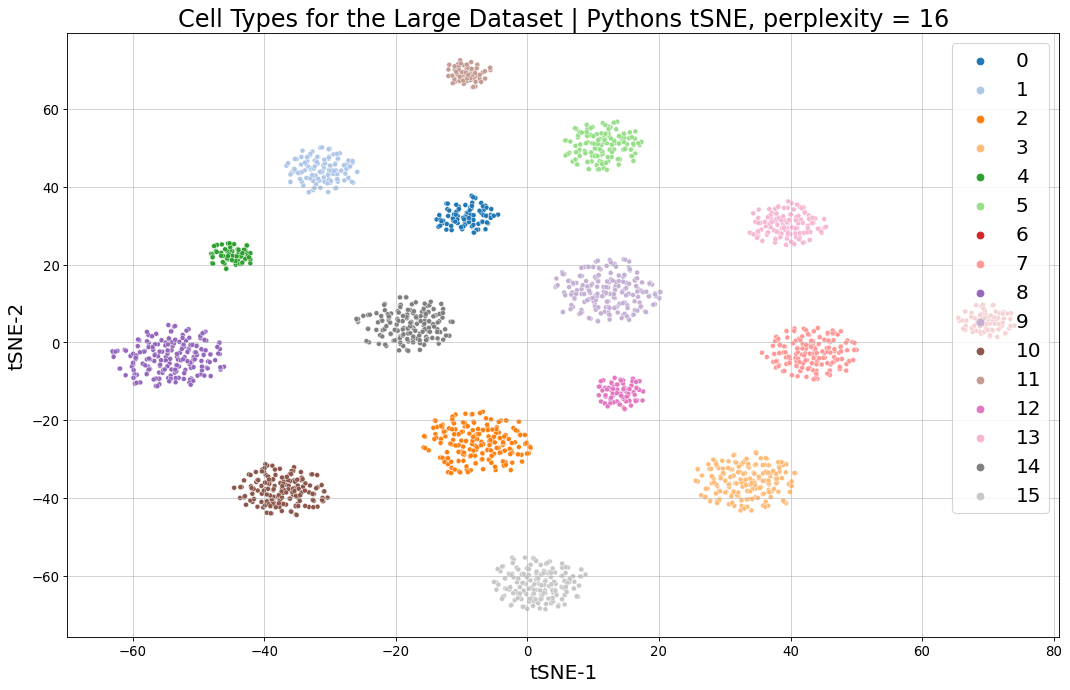

Figure 5: Canned tSNE to assign cell types for the large dataset


In [35]:
# Set plotting parameters
plt.figure(figsize=(16,10), dpi = 80)
plt.grid(linewidth=0.5)
plt.title('Cell Types for the Large Dataset | Pythons tSNE, perplexity = 16')
plt.xlabel('tSNE-1')
plt.ylabel('tSNE-2')

# Generate a scatter plot
sns.scatterplot(
    x=Y_ld[:,0], y=Y_ld[:,1],
    hue = large_gene_types,
    s = 20,
    palette=sns.color_palette("tab20", 16),
    data=ld
    )
plt.show()


print("Figure 5: Canned tSNE to assign cell types for the large dataset")

Great, we can see that the 2131 cells have been clustered by cell types into 16 clusters for the  for 16 different neural cell types. We can confirm for Moriarty that tSNE is a better method than PCA for cell classification of larger dimensity datasets. 

We can also somewhat visualize that this looks similar to the cell counts we counted Part 0; with some larger and some smaller clusters. 

In [36]:
cellcounts_l

,Cell Counts
0,89
1,117
2,194
3,181
4,61
5,133
6,83
7,157
8,197
9,193


### The perplexing impact of perplexity on tSNE

Given tSNE's heuristic nature, tSNE responds rather dramatically to even the smallest of changes. Changing a significant hyperparameter is definitely going to have it's impacts. 

The perplexity value in tSNE is a little poorly understood as compared to the other (and far more complicated) mathematical terms involved in the process. 

Perplexity can be referred to as a random guess about the number of close neighbors each point has. It makes an attempt to balance attention between local and global aspects of your data and has dramatic consequences on how your visualizations turn out.

As we vary the value of perplexity, we can see that the clustering generated by the model differs. The assigned value of perplexity largely depends on the number of observations in the dataset, and the number of potential clusters that can be generated. 

A general comment that I can make at this point is that keeping the perplexity closer to the tentative number of expected clusters is a method that seems to work. To put it crudely, I believe this is because perplexity count divides the number of observations in the dataset into chuncks based on local parameters; which is how the clusters would be classified in the first place.   

While van der Maaten recommends great plots at perplexity values between 5 and 50. The default setting for perplexity is 30, and though various data science forums discuss having a large perplexity can produce conserved, tightly clustered models, this again depends highly on the dataset. 

We will soon see that our model rejects the larger values due to a lack of data points, and plots tight clusters for increase in perplexity for the larger dataset. 

## Part 3.1: tSNE Multiplots, Small Dataset ~ local distill.pub implementation

Let us use the canned TSNE function available on sklearn to run several trials at varying perplexities similar to what we can see on distll.pub. While our plots may not be as beautifully represented, we can see similar results. 

_Method:_
1. Generate 6 plots in each run for both datasets using perplexities = 2, 5, 8, 30, 50, 100
2. Rerun the same function to show that tSNE generates non-identical plots for the exact same data when executed again. 

In [37]:
# Define a function that plots multiple tSNE plots over a range of perplexity values

mpl.rcParams.update({'font.size': 10})

# for the small dataset, 
def plot_tsne_sd():
    perplexities = [2, 5, 8, 30, 50, 100]
    Y = []
    X = sd

    for perp in perplexities:
        Y.append(TSNE(perplexity=perp).fit_transform(X))

    fig, axs = plt.subplots(2,int(len(perplexities)/2), figsize=(12, 8))
    axs = axs.ravel()
    k=8

    # set 8 colors for 8 cell types
    colormap = ['darkorange',    'lightcoral',  'maroon', 'olive',
             'indigo', 'teal', 'cyan',    'lime']

    for i in range(len(perplexities)):
        for j in range(len(sd)):
            
            axs[i].plot(Y[i][j,0], Y[i][j,1], linestyle="", marker='.',color=colormap[int(small_gene_types[j])])
            axs[i].set_xlabel('tsne-1')
            axs[i].set_ylabel('tsne-2')
            axs[i].set_title('tSNE Cell types for small dataset, \n perplexity = {}'.format(perplexities[i]))

    plt.tight_layout()

Figure 6: Run 1 - Canned tSNE to assign cell types for the small dataset, multiple perplexities = 2, 5, 8, 30, 50, 100


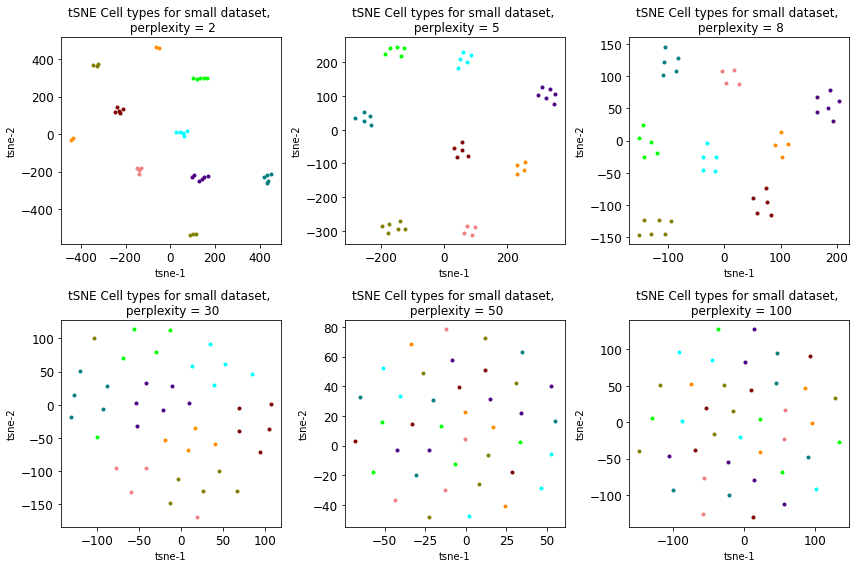

In [38]:
plot_tsne_sd()


print("Figure 6: Run 1 - Canned tSNE to assign cell types for the small dataset, multiple perplexities = 2, 5, 8, 30, 50, 100")

Figure 7: Run 2 - Canned tSNE to assign cell types for the small dataset, multiple perplexities = 2, 5, 8, 30, 50, 100


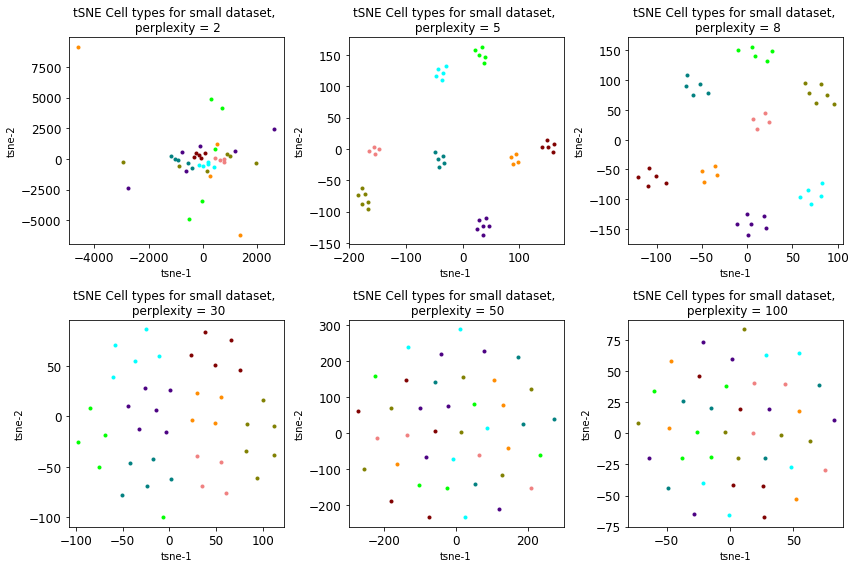

In [39]:
plot_tsne_sd()


print("Figure 7: Run 2 - Canned tSNE to assign cell types for the small dataset, multiple perplexities = 2, 5, 8, 30, 50, 100")

## Part 3.2: tSNE Multiplots, Large Dataset  ~ local distill.pub implementation

We will repeat the same for the larger dataset.

In [40]:
# Define a function that plots multiple tSNE plots over a range of perplexity values
mpl.rcParams.update({'font.size': 10})

# for the large dataset,
def plot_tsne_ld():
    
    perplexities = [2, 8, 16, 30, 50, 100]
    Y = []
    X = ld

    for perp in perplexities:
        Y.append(TSNE(perplexity=perp).fit_transform(X))

    fig, axs = plt.subplots(2,int(len(perplexities)/2), figsize=(12, 8))
    axs = axs.ravel()
    k=8

    # set 16 colors for 16 cell types
    colormap = ['xkcd:red',    'xkcd:green',  'xkcd:magenta', 'xkcd:blue',
          'xkcd:purple', 'xkcd:orange', 'xkcd:cyan',    'xkcd:lime',
          'xkcd:pink',   'xkcd:yellow', 'xkcd:teal',    'xkcd:lavender',
          'xkcd:brown',  'xkcd:maroon', 'xkcd:olive',   'xkcd:navy']

    for i in range(len(perplexities)):
        for j in range(len(ld)):
            
            axs[i].plot(Y[i][j,0], Y[i][j,1], linestyle="", marker='.',color=colormap[int(large_gene_types[j])])
            axs[i].set_xlabel('tsne-1')
            axs[i].set_ylabel('tsne-2')
            axs[i].set_title('tSNE Cell types for large dataset, \n perplexity = {}'.format(perplexities[i]))

    plt.tight_layout()

#### Warning: This function takes a minute to execute

Figure 8: Run 1 - Canned tSNE to assign cell types for the large dataset, multiple perplexities = 2, 5, 8, 30, 50, 100


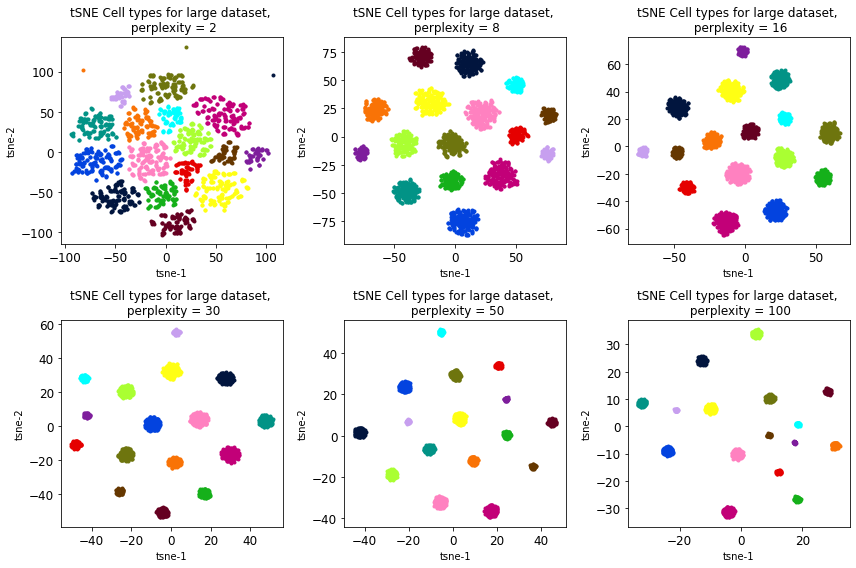

In [41]:
plot_tsne_ld()

print("Figure 8: Run 1 - Canned tSNE to assign cell types for the large dataset, multiple perplexities = 2, 5, 8, 30, 50, 100")

Figure 8: Run 2 - Canned tSNE to assign cell types for the large dataset, multiple perplexities = 2, 5, 8, 30, 50, 100


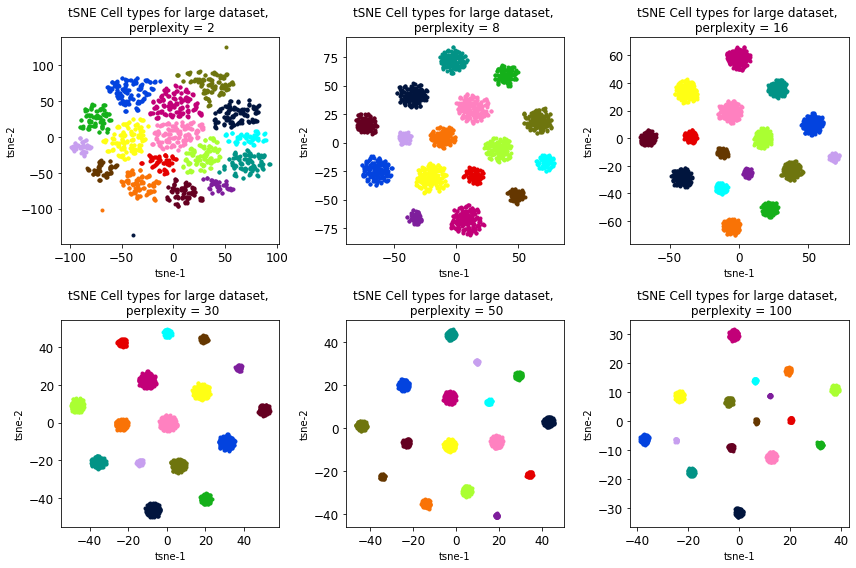

In [42]:
plot_tsne_ld()

print("Figure 9: Run 2 - Canned tSNE to assign cell types for the large dataset, multiple perplexities = 2, 5, 8, 30, 50, 100")

Looking at the plots generated, we can see how dramatically perplexity impacts clustering. 
> In the _smaller dataset_ we observe clustering for lower values of perplexity as the model checks for neighbors within the 40 observations. Beyond a particular value, we can see that the model seems to completely abandon the idea of tring to generate clusters and just throws out data points like confetti. This is because by nature, the ndimensionality reduction component of the tSNE algorithm tends to expand dense clusters and contract sparse ones in at attempt to achieving some form of homeostasis. I believe my comment on selecting a perplexity value close to the expected number of clusters (8) holds good for this case. At perplexity = 8, we see an almost identical plot to that generated by PCA just in terms of the clusters produced. 

> Conversely, for the _larger dataset_ with the higher number of observations (2131), we can see that at lower values of perplexity a 'fuzzy' output is produced. As we increase the values of perplexity, we can see that the clusters tend to become dense and conservative. In this case, the algorithm has sufficent data points to iterate over. I am curious to see if the points will scatter at a very large value of perplexity. 

In [102]:
# Run sklearn.manifold.TSNE at perplexity = 2130
Y_ld_scatter = TSNE(perplexity=2130).fit_transform(X_ld) 

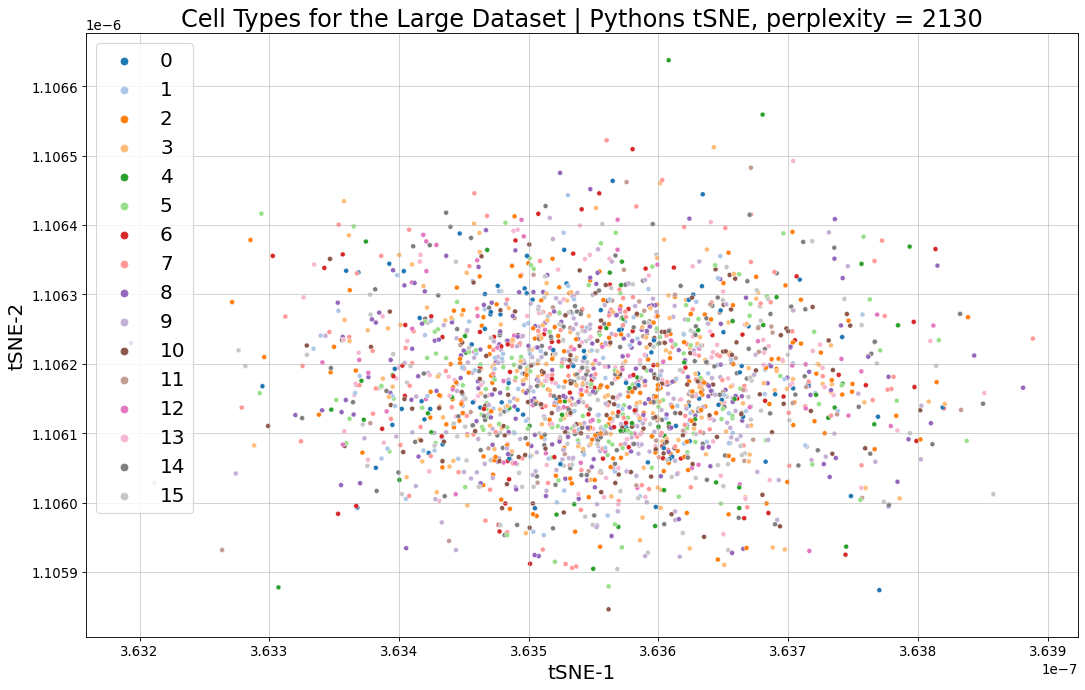

Figure 10: Canned tSNE to assign cell types for the large dataset at a perplexity value greater than the total numer of data points in the dataset


In [103]:
# Set plotting parameters
plt.figure(figsize=(16,10), dpi = 80)
plt.grid(linewidth=0.5)
plt.title('Cell Types for the Large Dataset | Pythons tSNE, perplexity = 2130')
plt.xlabel('tSNE-1')
plt.ylabel('tSNE-2')

# Generate a scatter plot
sns.scatterplot(
    x=Y_ld_scatter[:,0], y=Y_ld_scatter[:,1],
    hue = large_gene_types,
    s = 20,
    palette=sns.color_palette("tab20", 16),
    data=ld
    )
plt.show()


print("Figure 10: Canned tSNE to assign cell types for the large dataset at a perplexity value greater than the total numer of data points in the dataset")

Turns out my intuition for the perplexity values was correct. It tends to break clusters beyond a particular point that is close to the total number of observed datapoints. 

As an unsurprsing conclusion, the only way to truly know if you have what you need is by running several iterations with varying hyperparameters. 

# _Fin_


## Part 4: 

#### Dear Moriarty,

As this is my final project, I was motivated to look up how one might actually go about classifying 200 billion cells at less than $1/cell; in the interest of helping the friends I have made over the last 13 weeks retain their jobs. 

While PCA and tSNE are both great concepts, they might be a little too unsophisticated for classifying complex neural cell types. In the interest of delivering concrete results, it might help to look into other models and methods. 

With some literature reading, I came to understand that there are several methods that are used to classify neural cells, most interestingly those that employ multi-layer artificial neural networks. I came across a rather interesting method called the **_generalized leaky integrate-and-fire_** model that is used to classify neuronal cell types by agencies such as the Allen Brain Atlas (who, much to your disappointment, have already achieved what you hoped to achieve). 

The GLIF model predicts cell types not by single cell gene expression, but by neural spiking patterns, thus successfully classifying neural cell types of the human brain by a completely different parameter. 

More about the Allen Brain Atlas: https://celltypes.brain-map.org/#trans and GLIF models and their applications in classifying neural cell types: https://www.nature.com/articles/s41467-017-02717-4#Abs1 can be found here. 


And with that, our journey comes to an end. It was (occasionally) a pleasure working with you. 

Best,

**Aishwarya Chander**

## References: 

[1] https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b


[2] https://stats.stackexchange.com/questions/399868/why-does-larger-perplexity-tend-to-produce-clearer-clusters-in-t-sne


[3] https://distill.pub/2016/misread-tsne/


[4] https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a